In [1]:
import os, sys, fnmatch, re, itertools, warnings
import pandas as pd
import numpy as np
import seaborn as sns
from gurobipy import *
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from numpy import sqrt
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
init_notebook_mode(connected=True)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# Get Data

In [2]:
file = '/Users/scott/Projects/MR/dataset.xlsx'
data = pd.read_excel(file, header=1)
data.head()

,Ticket Created Date,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer count - Sub,Customer count - One
0,2016-04-21,533,984,507,239,240
1,2016-04-20,658,6035,485,225,210
2,2016-04-19,778,2450,500,196,231
3,2016-04-18,743,2502,527,192,240
4,2016-04-17,925,3080,488,217,209


In [3]:
# Clean Data
data = data.set_index(['Ticket Created Date'])
df = data.sort_index(ascending=True)
df = df.rename(columns={'Customer count - Sub': 'Customer Count - Sub', 
                        'Customer count - One': 'Customer Count - One'})
df.head()

,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer Count - Sub,Customer Count - One
Ticket Created Date,,,,,
2015-11-24,907,2947,717,307,386
2015-11-25,846,4290,641,306,359
2015-11-26,636,908,759,438,490
2015-11-27,848,1424,1359,387,465
2015-11-28,1063,1975,632,247,315


In [4]:
# Create Features
df['DOW'] = df.index.dayofweek
df['Order Count - Total'] = df['Order Count - Sub'] + df['Order Count - One']
df['Customer Count - Total'] = df['Customer Count - One'] + df['Customer Count - Sub']

In [5]:
# Create lag features for order count total
def create_oct_lag(df):
    for x in list(range(1,11)):
        col_name = 'OCT' + str(x)
        df[col_name] = df['Order Count - Total'] - df['Order Count - Total'].shift(x)
    return df

In [6]:
# Create lag features for customer count total
def create_cc_lag(df):
    for x in list(range(1,11)):
        col_name = 'CC' + str(x)
        df[col_name] = df['Order Count - Total'] - df['Order Count - Total'].shift(x)
    return df

In [7]:
create_oct_lag(df)
create_cc_lag(df)

,Total Tickets Opened,Order Count - Sub,Order Count - One,Customer Count - Sub,Customer Count - One,DOW,Order Count - Total,Customer Count - Total,OCT1,OCT2,...,CC1,CC2,CC3,CC4,CC5,CC6,CC7,CC8,CC9,CC10
Ticket Created Date,,,,,,,,,,,,,,,,,,,,,
2015-11-24,907,2947,717,307,386,1,3664,693,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-25,846,4290,641,306,359,2,4931,665,1267.0,NaN,...,1267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-26,636,908,759,438,490,3,1667,928,-3264.0,-1997.0,...,-3264.0,-1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-27,848,1424,1359,387,465,4,2783,852,1116.0,-2148.0,...,1116.0,-2148.0,-881.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-28,1063,1975,632,247,315,5,2607,562,-176.0,940.0,...,-176.0,940.0,-2324.0,-1057.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-29,1070,2352,735,297,378,6,3087,675,480.0,304.0,...,480.0,304.0,1420.0,-1844.0,-577.0,NaN,NaN,NaN,NaN,NaN
2015-11-30,832,1988,695,267,375,0,2683,642,-404.0,76.0,...,-404.0,76.0,-100.0,1016.0,-2248.0,-981.0,NaN,NaN,NaN,NaN
2015-12-01,845,1930,617,234,346,1,2547,580,-136.0,-540.0,...,-136.0,-540.0,-60.0,-236.0,880.0,-2384.0,-1117.0,NaN,NaN,NaN
2015-12-02,755,4718,671,265,333,2,5389,598,2842.0,2706.0,...,2842.0,2706.0,2302.0,2782.0,2606.0,3722.0,458.0,1725.0,NaN,NaN


# EDA

## Explore Data

In [8]:
def line_plot(df, title, ytitle, xtitle='Date'):
    traces = []
    for cols in df.columns:
        df2 = df[cols]
        traces.append(
            go.Scatter(
                x = df2.index,
                y = df2,
                mode = 'lines',
                opacity = 0.7,
                marker = {'size':6},
                name =  cols
            )
        )
    layout = go.Layout(
        title=title,
        xaxis=dict(
            title=xtitle
        ),
        yaxis=dict(
            title=ytitle
        ),
        bargap=0.1,
    )
    data = traces
    fig = go.Figure(data=data, layout=layout)
    return iplot(fig, filename='basic-line')

In [9]:
data['Total Tickets Opened'].describe()

count     150.000000
mean      727.073333
std       197.137233
min       354.000000
25%       583.750000
50%       729.500000
75%       845.750000
max      1734.000000
Name: Total Tickets Opened, dtype: float64

In [10]:
line_plot(df[['Total Tickets Opened']], 'Daily Tickets', 'Ticket Count')

In [11]:
# Line plot for all columns of original dataset
line_plot(df[['Total Tickets Opened', 'Order Count - Sub', 'Order Count - One', 
              'Customer Count - Sub', 'Customer Count - One']],'Line Plot','Ticket Count')

In [12]:
# Distribution of data
def bar_chart(df):
    data = [go.Histogram(x=df['Total Tickets Opened'])]
    layout = go.Layout(
        title='Ticket Distribution',
        xaxis=dict(
            title='Value'
        ),
        yaxis=dict(
            title='Count'
        ),
        bargap=0.1,
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='basic histogram')

In [13]:
bar_chart(df)

In [14]:
# Stacked Histogram of Total ticket count stacked by Day of week
def stacked_hist(df, plot_title, xtitle):
    traces = []
    for day in list(range(7)):
        x_val = df[df['DOW'] == day]['Total Tickets Opened']
        trace = go.Histogram(
            x=x_val,
            name = str(day),
            nbinsx=15
        )
        traces.append(trace)

    layout = go.Layout(
        title=plot_title,
        barmode="stack",
        xaxis=dict(
            title=xtitle
        )
    )
    fig = go.Figure(data=traces, layout=layout)
    return iplot(fig, filename='stacked_histogram')

In [15]:
stacked_hist(df, 'Stacked Bar Chart by Day of Week', 'Ticket Count')

<Figure size 432x288 with 0 Axes>

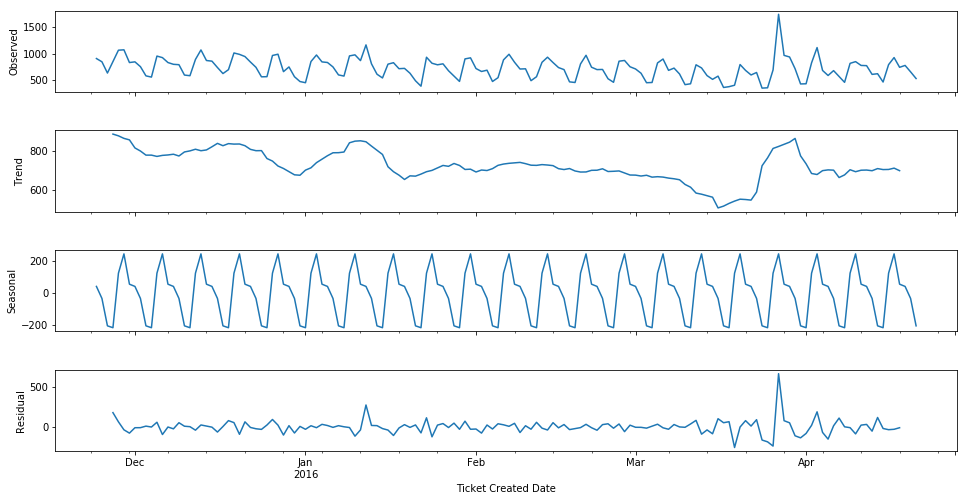

In [16]:
# View the decomposed time series data
decomposition = seasonal_decompose(df['Total Tickets Opened'], freq=7)

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [17]:
# Explore residuals
residuals = pd.DataFrame(decomposition.resid)
residuals 
line_plot(residuals, 'Residuals', 'Ticket Count')

## Test Stationarity

In [18]:
def test_stationarity(timeseries, cutoff = 0.01):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd = timeseries.rolling(10).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Test Stationarity')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[0] < dftest[4]['1%']:
        print('Reject the null hypothesis; it is stationary')
    else:
        print('Fail to reject the null hypothesis; it is not stationary')
    print('\n')    
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpsstest[0] < kpsstest[3]['1%']:
        print('Reject the null hypothesis; it is stationary')
    else:
        print('Fail to reject the null hypothesis; it is not stationary')

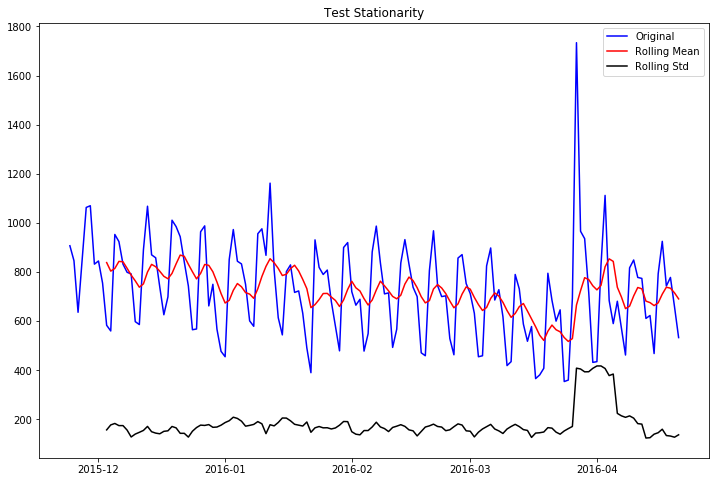

Results of Dickey-Fuller Test:
Test Statistic                  -2.116349
p-value                          0.237992
#Lags Used                      14.000000
Number of Observations Used    135.000000
Critical Value (1%)             -3.479743
Critical Value (5%)             -2.883198
Critical Value (10%)            -2.578320
dtype: float64
Fail to reject the null hypothesis; it is not stationary


Results of KPSS Test:
Test Statistic            0.636808
p-value                   0.019290
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis; it is stationary


In [19]:
test_stationarity(df['Total Tickets Opened'])

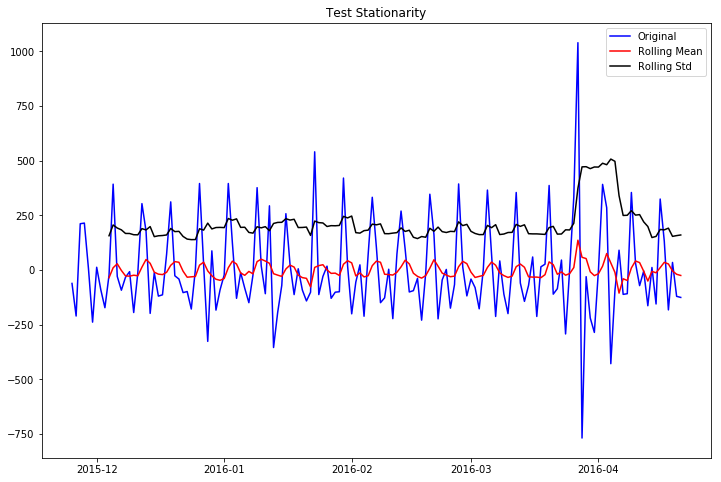

Results of Dickey-Fuller Test:
Test Statistic                -5.919877e+00
p-value                        2.521208e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.350000e+02
Critical Value (1%)           -3.479743e+00
Critical Value (5%)           -2.883198e+00
Critical Value (10%)          -2.578320e+00
dtype: float64
Reject the null hypothesis; it is stationary


Results of KPSS Test:
Test Statistic            0.069949
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Reject the null hypothesis; it is stationary


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value



In [20]:
# First Difference Stationarity
df['First Difference'] = df['Total Tickets Opened'] - df['Total Tickets Opened'].shift(1)  
test_stationarity(df['First Difference'].dropna(inplace=False))

## Correlation and Feature Engineering

In [21]:
def heatmap_corr(df): 
    labels = [x for x in df.corr().columns]
    trace = go.Heatmap(
        z=df.corr().values,
        x=labels,
        y=labels
        )
    layout = go.Layout(
        title='Heatmap of Correlation',
        yaxis=go.layout.YAxis(
        automargin=True
        )
    )
    data = [trace]
    fig = go.Figure(data=data, layout=layout)

    return iplot(fig, filename='heatmap')

In [22]:
# Correlation of original dataset
heatmap_corr(df[['Total Tickets Opened', 'Order Count - Sub', 'Order Count - One', 
                 'Customer Count - Sub', 'Customer Count - One']])

In [23]:
# Heatmap of correlation with all features
heatmap_corr(df)

In [24]:
def corr_plot(x, y):
    trace = go.Scatter(
        x = x,
        y = y,
        mode = 'markers'
    )
    data = [trace]
    return iplot(data, filename='basic-scatter')

In [25]:
# Correlation of Tickets and Customer Count Subscription
corr_plot(df['Total Tickets Opened'], df['Customer Count - Sub'])

In [26]:
# Return a line plot with the normalized data. Easier to compare when data is normalized.
def normalized_plot(df):
    x = df.values #returns a numpy array
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    scaled_df = pd.DataFrame(x_scaled, columns=df.columns)
    return line_plot(scaled_df, 'Normalized Plot', 'Normalized Ticket Count')

In [27]:
normalized_plot(df[['Total Tickets Opened', 'Order Count - Sub']])

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [28]:
def corr_plot_DOW(x_col, y_col):
    fig = {
        'data': [
            {
                'x': df[df['DOW']==day][x_col],
                'y': df[df['DOW']==day][y_col],
                'name': day, 'mode': 'markers',
            } for day in list(range(7))
        ],
        'layout': {
            'xaxis': {'title': x_col, 'type': 'log'},
            'yaxis': {'title': 'Ticket Count'}
        }
    }
    return iplot(fig, filename='grouped-scatter')

In [29]:
# Correlation of Ticket Count and Order Count Total w/ Day of week
corr_plot_DOW('Order Count - Total', 'Total Tickets Opened')

 -  There is a weak positive correlation with Order Count Total and Total Tickets Opened. All of the days with the highest Order Count - Total happen to fall on Tuesday. However, it does not translate to a higher ticket count on Tuesday

In [30]:
# Correlation of Ticket Count and Order Count Total w/ Day of week
corr_plot_DOW('Customer Count - Sub', 'Total Tickets Opened')

# Seasonal Persistence Model

In [31]:
# Splits data based on split(percentage)
splits = [.5, .6, .7, .8, .9]
def train_test_split(df, split):
    trainsize = int(len(data) * split)
    return df[:trainsize], df[trainsize:]

In [32]:
# Function that loops through each split
# In each split the model will find the best # of previous weeks mean to make predictions
def seasonal_persistence(df):
    results_dict = {'Splits': list(), 'RMSE': list()}
    
    for split in splits: 
        train, test = train_test_split(df, split)
        #Evaluate up to the last 10 weeks mean
        weeks = [i for i in range(1,30)]
        best_rmse = 10000
        for week in weeks:
            try:
                # Walk forward validation
                history = [x for x in train.values]
                predictions = []
                for i in range(len(test)):
                    #collect observation
                    obs = []
                    for d in range(1, week+1):
                        obs.append(history[-(d*7)])
                    #make prediction
                    yhat = np.mean(obs)
                    predictions.append(yhat)
                    # Observation
                    history.append(test[i])
                future_forecast = pd.DataFrame(predictions,
                                   index=test.index,
                                   columns=['Predictions'])
                rmse = sqrt(mean_squared_error(test, predictions))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_forecast = future_forecast
                else:
                    continue
            except:
                results_dict['Splits'].append(split)
                results_dict['RMSE'].append(best_rmse)
                break
    return results_dict

In [33]:
sp_results = seasonal_persistence(df['Total Tickets Opened'])

In [34]:
sp_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [141.69202371105203,
  155.71435771282194,
  176.68818363464806,
  176.40035441301427,
  56.481041712389356]}

# Holts Winter Model

In [37]:
# Holts Winter
def holts(data):
    results_dict = {'Splits': list(), 'RMSE': list()}
    for split in splits: 
        train, test = train_test_split(data, split)
   
        # Create and fit auto arima model
        hw_model = ExponentialSmoothing(train, seasonal_periods=7, 
                                        trend='add', seasonal='add', 
                                        damped=True).fit(use_boxcox=False, remove_bias=False)

        # Make predictions and plot
        forecast = hw_model.predict(start=test.index[0], end=test.index[-1])
        future_forecast = pd.DataFrame(forecast,
                                       index=test.index,
                                       columns=['Predictions'])
        pd.concat([test, future_forecast], axis=1)

        #Print RMSE
        rmse = sqrt(mean_squared_error(test, future_forecast))
        print('RMSE: %f' % rmse)

        #Determining Forecast Bias
        residuals = [test[i]-forecast[i] for i in range(len(test))] 
        bias = sum(residuals) * 1.0/len(test)
        print('Bias: %f' % bias)

        # Summary Statistics of bias
        #print(pd.DataFrame(residuals).describe())
        
        results_dict['Splits'].append(split)
        results_dict['RMSE'].append(rmse)
    return results_dict

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 143.757992
Bias: -32.818118


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 155.024280
Bias: -39.125206


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 172.558173
Bias: 13.870443


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 241.102578
Bias: 169.004781


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 109.124133
Bias: 38.738059


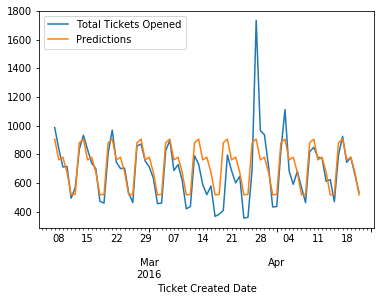

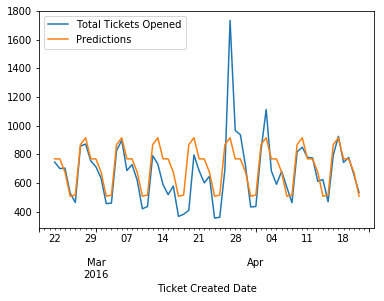

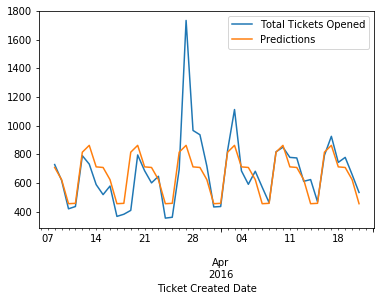

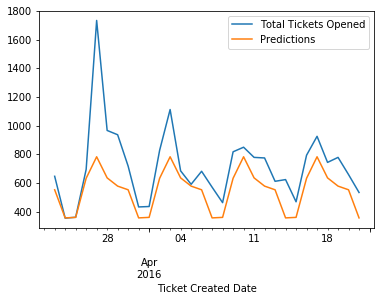

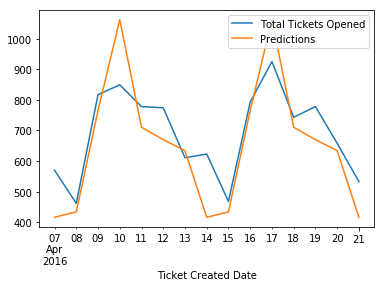

In [38]:
hw_results = holts(df['Total Tickets Opened'])

In [39]:
hw_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [143.7579922586709,
  155.0242799851283,
  172.55817263454307,
  241.10257783666648,
  109.1241330333621]}

# SARIMAX Model

## Feature Selection for SARIMAX

In [40]:
# Use Recursive feature selection
def feature_selection(df, num_features):
    df2 = df #.drop(columns=['Order Count - Total', 'Customer count - Total'])
    feat_list = []
    X = df2.iloc[:,1:]
    y = np.ravel(df2.iloc[:,:1])
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), num_features)
    fit = rfe.fit(X, y)

    # print('Features:')
    names = df2.columns.values[1:]
    for x in range(len(fit.support_)):
        if fit.support_[x]:
            # print(names[x])
            feat_list.append(names[x])
    ticks = [i for i in range(len(names))]
    # plt.bar(ticks, fit.ranking_)
    # plt.xticks(ticks, names, rotation=90)
    # plt.show()
    return feat_list

## Auto Arima Model

In [41]:
# Create Auto Arima model that will take in both endogenous and exogenous features
def autoarima_model(en, split, count, ex=None):
    train_size = int(len(en) * split)
    endog_data = en
    train, test = endog_data[:train_size], endog_data[train_size:]
    if ex is None:
        exog_data=None
    else:
        exog_data = ex
        exog_train, exog_test = exog_data[0:train_size], exog_data[train_size:]
        
    # Create and fit auto arima model
    stepwise_model = auto_arima(endog_data, exogenous=exog_data, start_p=1, start_q=1,
                               max_p=3, max_q=7, m=7,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    stepwise_model.aic()
    stepwise_model.fit(train)
    
    # Make predictions and plot
    forecast = stepwise_model.predict(n_periods=len(test))
    future_forecast = pd.DataFrame(forecast,
                                   index=test.index,
                                   columns=['Predictions' + str(count)])
    #pd.concat([test, future_forecast], axis=1).plot()
    #print(stepwise_model)
    
    #Print RMSE
    rmse = sqrt(mean_squared_error(test, future_forecast))
    #print('RMSE: %f' % rmse)
    
    #Determining Forecast Bias
    #residuals = [test[i]-forecast[i] for i in range(len(test))] 
    #bias = sum(residuals) * 1.0/len(test)
    #print('Bias: %f' % bias)
    
    # Summary Statistics of bias
    #print(pd.DataFrame(residuals).describe())
    
    return rmse, stepwise_model, residuals, pd.concat([test, future_forecast], axis=1)

## Function to Return Best Models

In [ ]:
# Find out which feature amount is best
def aa_model(df):
    results_dict = {'Splits': list(), 'RMSE': list()}
    for split in splits: 
        best_rmse = 10000
        for x in list(range(1,11)):
            features_list = feature_selection(df.dropna(inplace=False), x)
            ex = df[features_list].dropna(inplace=False)
            en = df['Total Tickets Opened'][len(df)-len(ex):]
            try:
                rmse, stepwise_model, residuals, predictions = autoarima_model(en=en,
                                                                               split=split,
                                                                               count=x,
                                                                               ex=ex)
                # Create dataset of all predictions
                if x == 1:
                    all_preds = predictions
                else:
                    all_preds = pd.merge(all_preds, predictions[['Predictions' + str(x)]], 
                                how='left', left_index=True, right_index=True)
                # Keep metrics of the best performing models    
                if rmse < best_rmse:
                    best_features = features_list
                    best_rmse = rmse
                    best_model = stepwise_model
                    best_residuals = residuals
                    best_predictions = predictions
                else:
                    continue
            except:
                continue

        results_dict['Splits'].append(split)
        results_dict['RMSE'].append(best_rmse)
    return results_dict

In [43]:
s_results = aa_model(df)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1767.039, BIC=1784.774, Fit time=1.068 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1854.557, BIC=1863.425, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1820.753, BIC=1835.533, Fit time=0.511 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1771.066, BIC=1785.845, Fit time=0.692 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1765.709, BIC=1786.399, Fit time=1.630 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1801.952, BIC=1819.686, Fit time=1.111 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1814.252, BIC=1829.032, Fit time=0.351 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1768.869, BIC=1795.471, Fit time=3.152 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 7); AIC=1581.793, BIC=1617.093, Fit time=2.652 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1578.421, BIC=1604.896, Fit time=1.751 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1582.146, BIC=1614.504, Fit time=2.029 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=1591.760, BIC=1624.119, Fit time=2.143 seconds
Total fit time: 28.993 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1559.268, BIC=1588.541, Fit time=1.713 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1649.547, BIC=1670.038, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1633.106, BIC=1659.451, Fit time=1.373 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1581.692, BIC=1608.038, Fit time=1.955 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1585.834, BIC=1618.034, Fit time=2.210 seconds
Fit AR

Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1520.288, BIC=1560.753, Fit time=2.989 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=1530.155, BIC=1576.401, Fit time=3.667 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 1, 7); AIC=1520.335, BIC=1563.690, Fit time=2.676 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 7); AIC=1537.258, BIC=1574.833, Fit time=0.887 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 2, 7); AIC=1524.180, BIC=1567.535, Fit time=3.291 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 7); AIC=1520.793, BIC=1567.039, Fit time=3.631 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1521.013, BIC=1558.588, Fit time=2.290 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1521.858, BIC=1565.213, Fit time=2.704 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=1528.127, BIC=1571.482, Fit time=3.148 seconds
Total fit time: 47.282 seconds
Fit AR

Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=1763.676, BIC=1787.323, Fit time=1.952 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(2, 1, 1, 7); AIC=1772.295, BIC=1801.853, Fit time=3.430 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 7); AIC=1768.855, BIC=1789.545, Fit time=2.259 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(2, 1, 1, 7); AIC=1785.398, BIC=1817.912, Fit time=2.669 seconds
Total fit time: 38.201 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1583.718, BIC=1604.359, Fit time=1.383 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1678.158, BIC=1689.953, Fit time=0.116 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1662.083, BIC=1679.775, Fit time=0.549 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1608.749, BIC=1626.442, Fit time=1.464 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1584.101, BIC=1607.691, Fit time=2.140 seconds
Fit AR

Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1580.746, BIC=1610.019, Fit time=2.171 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1576.358, BIC=1608.558, Fit time=2.432 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1606.608, BIC=1635.881, Fit time=1.143 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1593.696, BIC=1628.823, Fit time=3.062 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1615.244, BIC=1641.589, Fit time=0.623 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1596.177, BIC=1634.232, Fit time=3.013 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1589.587, BIC=1624.714, Fit time=2.239 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1604.117, BIC=1633.389, Fit time=1.733 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 1, 7); AIC=1573.050, BIC=1608.177, Fit time=2.437 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_o

Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 2, 7); AIC=1537.389, BIC=1586.525, Fit time=3.683 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1534.676, BIC=1578.031, Fit time=2.950 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1568.231, BIC=1605.805, Fit time=0.740 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1554.537, BIC=1595.002, Fit time=2.192 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1536.989, BIC=1583.235, Fit time=3.362 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1536.411, BIC=1582.656, Fit time=3.522 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1533.627, BIC=1582.762, Fit time=3.232 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1532.290, BIC=1578.535, Fit time=2.883 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1554.369, BIC=1597.724, Fit time=1.009 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_o

Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=1582.778, BIC=1609.316, Fit time=2.875 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=1573.520, BIC=1603.008, Fit time=3.252 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 1, 7); AIC=1565.982, BIC=1592.521, Fit time=2.418 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 7); AIC=1613.578, BIC=1634.219, Fit time=0.656 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 7); AIC=1569.994, BIC=1599.481, Fit time=3.519 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1569.726, BIC=1590.368, Fit time=2.054 seconds
Total fit time: 45.541 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1585.848, BIC=1609.438, Fit time=1.622 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1679.333, BIC=1694.077, Fit time=0.076 seconds
Fit ARIMA: order=(

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1538.064, BIC=1575.639, Fit time=2.475 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1558.982, BIC=1590.776, Fit time=0.720 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1536.168, BIC=1576.633, Fit time=3.047 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1545.806, BIC=1583.380, Fit time=2.688 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1537.513, BIC=1580.869, Fit time=3.215 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 7); AIC=1551.228, BIC=1588.802, Fit time=3.325 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 7); AIC=1523.100, BIC=1566.456, Fit time=3.542 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 2, 7); AIC=1532.361, BIC=1581.497, Fit time=4.370 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1561.364, BIC=1601.829, Fit time=0.819 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1542.450, BIC=1594.476, Fit time=3.730 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1546.738, BIC=1590.093, Fit time=2.861 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1538.573, BIC=1587.709, Fit time=3.328 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1536.681, BIC=1582.926, Fit time=2.901 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1538.406, BIC=1590.432, Fit time=3.584 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1535.871, BIC=1579.226, Fit time=2.913 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1570.229, BIC=1610.694, Fit time=0.920 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=1539.822, BIC=1586.067, Fit time=4.235 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1654.043, BIC=1677.576, Fit time=0.876 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1606.412, BIC=1629.946, Fit time=1.449 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1597.770, BIC=1627.186, Fit time=1.901 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1631.526, BIC=1655.059, Fit time=0.530 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1595.120, BIC=1627.478, Fit time=2.613 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1579.058, BIC=1608.474, Fit time=1.750 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1615.450, BIC=1638.983, Fit time=1.251 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1558.891, BIC=1588.308, Fit time=1.940 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 1, 

Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 7); AIC=1524.342, BIC=1564.806, Fit time=3.235 seconds
Total fit time: 60.648 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1533.302, BIC=1570.877, Fit time=2.077 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1591.428, BIC=1620.332, Fit time=0.071 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1577.325, BIC=1612.009, Fit time=1.939 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1545.424, BIC=1580.108, Fit time=2.072 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1537.049, BIC=1577.513, Fit time=2.882 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1556.040, BIC=1590.724, Fit time=0.736 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=1536.832, BIC=1577.297, Fit time=2.898 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1536.088, BIC=1579.443, Fit time=3.078 seconds
Fit AR

Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1771.213, BIC=1788.948, Fit time=0.980 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=1783.583, BIC=1801.318, Fit time=0.801 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 1, 7); AIC=1764.827, BIC=1788.473, Fit time=1.798 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 1, 1, 7); AIC=1785.112, BIC=1814.670, Fit time=2.501 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1765.600, BIC=1786.291, Fit time=1.317 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 1, 7); AIC=1762.228, BIC=1788.830, Fit time=3.036 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 0, 7); AIC=1782.471, BIC=1806.118, Fit time=1.876 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 2, 7); AIC=1777.560, BIC=1807.118, Fit time=4.107 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1607.270, BIC=1633.616, Fit time=0.550 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1584.379, BIC=1619.506, Fit time=2.449 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1573.865, BIC=1606.065, Fit time=2.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1594.804, BIC=1621.149, Fit time=1.459 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1563.500, BIC=1595.700, Fit time=2.028 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=1602.953, BIC=1626.371, Fit time=1.188 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 7); AIC=1564.054, BIC=1599.181, Fit time=2.220 seconds
Total fit time: 18.250 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1586.142, BIC=1618.342, Fit time=1.697 seconds
Fit ARIMA: order=(

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1539.193, BIC=1579.658, Fit time=2.162 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1593.428, BIC=1625.222, Fit time=0.076 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1579.301, BIC=1616.876, Fit time=1.789 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1547.082, BIC=1584.657, Fit time=2.131 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1538.776, BIC=1582.131, Fit time=2.839 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1552.198, BIC=1592.663, Fit time=2.284 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1538.503, BIC=1584.749, Fit time=3.276 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1545.974, BIC=1589.329, Fit time=3.142 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1536.223, BIC=1585.359, Fit time=3.327 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

In [44]:
s_results

{'Splits': [0.5, 0.6, 0.7, 0.8, 0.9],
 'RMSE': [144.2328086814121,
  160.17677313293052,
  170.7249280216313,
  222.31486730178557,
  103.86439745262602]}

# Model Evaluations

## RMSE evaluation

In [45]:
def create_results_df(results1, results2, results3):
    temp_df = pd.DataFrame(results1['Splits'])
    temp_df['Seasonal Persistance'] = results1['RMSE']
    temp_df['Holts Winter'] = results2['RMSE']
    temp_df['SARIMAX'] = results3['RMSE']
    temp_df = temp_df.rename(columns={0:'Training Split'}).set_index(['Training Split']).T
    temp_df['Mean RMSE'] = temp_df.mean(axis=1)
    return temp_df

In [46]:
results_df = create_results_df(sp_results, hw_results, s_results)

In [47]:
results_df

Training Split,0.5,0.6,0.7,0.8,0.9,Mean RMSE
Seasonal Persistance,141.692024,155.714358,176.688184,176.400354,56.481042,141.395192
Holts Winter,143.757992,155.024280,172.558173,241.102578,109.124133,164.313431
SARIMAX,144.232809,160.176773,170.724928,222.314867,103.864397,160.262755


# Make Forecasts

## Holts Winter Forecast

In [48]:
# Holts Winter
def holts_forecast(data):
    train, test = train_test_split_14(data['Total Tickets Opened'])
    # Create and fit auto arima model
    hw_model = ExponentialSmoothing(train, seasonal_periods=7, 
                                    trend='add', seasonal='add', 
                                    damped=True).fit(use_boxcox=False, remove_bias=False)
    # Make predictions and plot
    forecast = hw_model.predict(start=test.index[0], end=test.index[-1])
    future_forecast = pd.DataFrame(forecast,
                                   index=test.index,
                                   columns=['Predictions'])
    #Print RMSE
    rmse = sqrt(mean_squared_error(test, future_forecast))
    print('RMSE: %f' % rmse)
    
    return rmse, pd.concat([test, future_forecast], axis=1)

## SARIMAX Forecast

In [60]:
def autoarima_model_forecast(en, ex=None):
    train_size = int(len(en) - 14)
    endog_data = en
    train, test = endog_data[:train_size], endog_data[train_size:]
    if ex is None:
        exog_data=None
    else:
        exog_data = ex
        exog_train, exog_test = exog_data[0:train_size], exog_data[train_size:]
        
    # Create and fit auto arima model
    stepwise_model = auto_arima(endog_data, exogenous=exog_data, start_p=1, start_q=1,
                               max_p=3, max_q=7, m=7,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    #stepwise_model.aic()
    stepwise_model.fit(train)
    
    # Make predictions and plot
    forecast = stepwise_model.predict(n_periods=len(test))
    future_forecast = pd.DataFrame(forecast,
                                   index=test.index,
                                   columns=['Predictions'])
    #Print RMSE
    rmse = sqrt(mean_squared_error(test, future_forecast))
    print('RMSE: %f' % rmse)
    
    return rmse, pd.concat([test, future_forecast], axis=1)

In [61]:
# Find out which feature amount is best
def aa_model_forecast(df):
    best_rmse = 10000
    for x in list(range(1,11)):
        features_list = feature_selection(df.dropna(inplace=False), x)
        ex = df[features_list].dropna(inplace=False)
        en = df['Total Tickets Opened'][len(df)-len(ex):]
        rmse, predictions = autoarima_model_forecast(en=en, ex=ex)

        # Keep metrics of the best performing models    
        if rmse < best_rmse:
            best_features = features_list
            best_rmse = rmse
            best_predictions = predictions
        else:
            continue

    return best_rmse, best_predictions

## Seasonal Persistence Forecast

In [51]:
def seasonal_persistence_forecast(data):
    train, test = train_test_split_14(data['Total Tickets Opened'])
    # Evaluate up to the last 30 weeks mean
    weeks = [i for i in range(1,30)]
    best_rmse = 10000
    for week in weeks:
        try:
            # Walk forward validation
            history = [x for x in train.values]
            predictions = []
            for i in range(len(test)):
                #collect observation
                obs = []
                for d in range(1, week+1):
                    obs.append(history[-(d*7)])
                #make prediction
                yhat = np.mean(obs)
                predictions.append(yhat)
                # Observation
                history.append(test[i])
            future_forecast = pd.DataFrame(predictions,
                               index=test.index,
                               columns=['Predictions'])
            rmse = sqrt(mean_squared_error(test, predictions))
            if rmse < best_rmse:
                best_rmse = rmse
                best_forecast = pd.concat([test, future_forecast], axis=1)
            else:
                continue
        except:
            break
    return best_rmse, best_forecast

## Visualize Results

In [52]:
# Create function to split data for the last 14 days
def train_test_split_14(data):
    trainsize = len(data) - 14
    return data[:trainsize], data[trainsize:]

In [65]:
# Create function that combines forcasts
def combined_forecasts(data):
    hw_rmse, hw_forecast = holts_forecast(data)
    sp_rmse, sp_forecast = seasonal_persistence_forecast(data)
    s_rmse, s_forecast = aa_model_forecast(data)
    temp_df = sp_forecast
    temp_df = temp_df.rename(columns={'Predictions': 'SP Predictions'})
    temp_df = temp_df.merge(hw_forecast[['Predictions']].rename(columns={'Predictions': 'HW Predictions'})
    ,how='left', left_index=True, right_index=True)
    temp_df = temp_df.merge(s_forecast[['Predictions']].rename(columns={'Predictions': 'S Predictions'})
                            ,how='left', left_index=True, right_index=True)
    return temp_df

In [66]:
all_forecasts = combined_forecasts(df)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



RMSE: 100.075655
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1767.039, BIC=1784.774, Fit time=0.778 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=1854.557, BIC=1863.425, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1820.753, BIC=1835.533, Fit time=0.381 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1771.066, BIC=1785.845, Fit time=0.546 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1765.709, BIC=1786.399, Fit time=1.261 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1801.952, BIC=1819.686, Fit time=0.782 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1814.252, BIC=1829.032, Fit time=0.235 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1768.869, BIC=1795.471, Fit time=2.284 seconds
Fit ARIMA: order=(0, 1, 1) seaso

In [73]:
line_plot(all_forecasts, 'Forecast', 'Ticket Count')

In [74]:
# Plot of the SP Forecast Results V 
line_plot(all_forecasts[['Total Tickets Opened', 'SP Predictions']], 'Seasonal Persistence Forecast', 'Ticket Count')

# Scheduler

## Scheduler Functions


In [75]:
# Get phone hours based on forecast
def get_phone_hours(t_count):
    aht = 20 # average handle time in minutes
    exp_phone_tickets = .3 * t_count # expected phone tickets
    expected_hours = exp_phone_tickets * aht / 60 # expected hours
    return expected_hours

In [76]:
# Get chat hours based on forecast
def get_chat_hours(t_count):
    aht = 10 # average handle time in minutes
    exp_chat_tickets = .5 * t_count # expected phone tickets
    expected_hours = exp_chat_tickets * aht / 60 # expected hours
    
    return expected_hours

In [77]:
# Get email hours based on forecast
def get_email_hours(t_count):
    aht = 6 # average handle time in minutes
    exp_email_tickets = .2 * t_count # expected phone tickets
    expected_hours = exp_email_tickets * aht / 60 # expected hours
    return expected_hours

In [78]:
# Use the above functions to calculate total hours
def get_total_hours(t_count):
    phone_hours = get_phone_hours(t_count)
    chat_hours = get_chat_hours(t_count)
    email_hours = get_email_hours(t_count)
    total_hours = (phone_hours + chat_hours + email_hours) / .85  # Expect workers to productive .85 percent of the time
    return total_hours

In [79]:
def get_shifts(ticket_forecast):
    shift_requirements = [int(get_total_hours(x)/8) for x in ticket_forecast]
    shift_list = [str(x) for x in sp_forecast.index.date]
    return shift_requirements, shift_list

In [96]:
# View the predictions
sp_forecast = all_forecasts[['Total Tickets Opened', 'SP Predictions']].rename(columns={'SP Predictions': 'Predictions'})
sp_forecast['Predictions']

Ticket Created Date
2016-04-08    488.8750
2016-04-09    833.8125
2016-04-10    969.8750
2016-04-11    770.1250
2016-04-12    750.9375
2016-04-13    678.6250
2016-04-14    493.3125
2016-04-15    474.0625
2016-04-16    821.6875
2016-04-17    961.3750
2016-04-18    759.7500
2016-04-19    746.7500
2016-04-20    670.3750
2016-04-21    496.9375
Name: Predictions, dtype: float64

In [98]:
analyze_df = sp_forecast

In [99]:
def analyze_shifts(df):
    temp_df = df
    sr, sl = get_shifts(temp_df['Predictions'])
    ar, al = get_shifts(temp_df['Total Tickets Opened'])
    temp_df['Forecasted Shift Requirements'] = sr
    temp_df['Actual Shift Requirements'] = ar
    temp_df['Difference'] = temp_df['Actual Shift Requirements'] - temp_df['Forecasted Shift Requirements']
    return temp_df[['Actual Shift Requirements', 'Forecasted Shift Requirements', 'Difference']]

In [100]:
# Shows the difference in shift requirements based on actual data v forecasted data
analyze_shifts(analyze_df)

,Actual Shift Requirements,Forecasted Shift Requirements,Difference
Ticket Created Date,,,
2016-04-08,13,14,-1
2016-04-09,24,24,0
2016-04-10,25,29,-4
2016-04-11,23,23,0
2016-04-12,23,22,1
2016-04-13,18,20,-2
2016-04-14,18,14,4
2016-04-15,13,14,-1
2016-04-16,23,24,-1


In [101]:
shift_req_df = analyze_shifts(analyze_df)

In [102]:
line_plot(shift_req_df[['Actual Shift Requirements', 'Forecasted Shift Requirements']],
          'Shift Requirements: Forecast v Prediction', 'Required Shifts')

In [103]:
def scheduler(ticket_forecast):
    ## Create a list of workers
    workerList = ['Employee' + str(x) for x in range(1,36)]
    
    # 
    shiftReq, shiftList = get_shifts(ticket_forecast)
    # Define shift requirements
    shiftRequirements  = { s : shiftReq[i] for i,s in enumerate(shiftList) }

    # Create Availability for each worker. Assuming workers are all available
    availability = pd.DataFrame(np.ones((len(workerList), len(shiftList))), index=workerList, columns=shiftList)

    # Create dictionary of final worker availability
    avail = {(w,s) : availability.loc[w,s] for w in workerList for s in shiftList}

    ## Input assumptions
    # Range of shifts that every workers is required to stay between
    minShifts = 6
    maxShifts = 10
    
    m = Model('Scheduler')
    
    # Assignment variables: x[w,s] == 1 if worker w is assigned to shift s.
    x = m.addVars(avail, vtype=GRB.BINARY, name='x')
    
    # Slack variables for each shift constraint so that the shifts can be satisfied
    slacks = m.addVars(shiftList, name='Slack')

    # Variable to represent the total slack
    totalSlack = m.addVar(name='totalSlack' )

    # Variables to count the total shifts worked by each other
    totalShifts = m.addVars(workerList, name='totalShifts')

    # Constraint: Ensure each worker stays within min and max shift bounds
    minShiftsConstr = m.addConstrs(((
        x.sum(w,'*') >= minShifts for w in workerList)
        ), name='minShifts')

    maxShiftsConstr = m.addConstrs(((
        x.sum(w,'*') <= maxShifts for w in workerList)
        ), name='maxShifts')

    # Constraint: assign exactly shiftRequirement[s] workers to each shift s, plus the slack
    reqCts = m.addConstrs((
        slacks[s] + x.sum('*', s) == shiftRequirements[s] 
        for s in shiftList), '_')

    # Constraint: set totSlack equal to the total slack
    m.addConstr(totalSlack == slacks.sum(), 'totalSlack')

    # Constraint: compute the total number of shifts for each worker
    m.addConstrs((
        totalShifts[w] == x.sum(w) 
        for w in workerList), 'totalShifts')

    # Objective: minimize the total slack
    m.setObjective(totalSlack)

    m.optimize()

    sol = pd.DataFrame(data={'Solution':m.X}, index=m.VarName)
    sol = sol.iloc[0:len(x)]

    dashboard = pd.DataFrame(index = workerList, columns = shiftList)
    for w in workerList:
        for s in shiftList:
            dashboard.at[w,s] = sol.loc['x['+w+','+s+']',][0]

    return dashboard

In [104]:
scheduler_df = scheduler(sp_forecast['Predictions'])

Academic license - for non-commercial use only
Optimize a model with 120 rows, 540 columns and 2024 nonzeros
Variable types: 50 continuous, 490 integer (490 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 3e+01]
Found heuristic solution: objective 80.0000000
Presolve removed 36 rows and 36 columns
Presolve time: 0.00s
Presolved: 84 rows, 504 columns, 1484 nonzeros
Variable types: 0 continuous, 504 integer (490 binary)

Root relaxation: objective 0.000000e+00, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 0 nodes (47 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 0 80 

Optimal solution found (tolerance 1

In [105]:
# View Schedule
scheduler_df

,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21
Employee1,1,1,1,1,1,-0,-0,-0,1,1,1,1,-0,1
Employee2,-0,1,1,1,0,-0,1,1,1,1,1,1,-0,1
Employee3,-0,1,1,-0,1,1,1,-0,1,1,-0,1,1,-0
Employee4,1,1,1,1,1,1,-0,1,1,1,0,1,-0,-0
Employee5,-0,1,1,-0,1,1,1,-0,1,1,1,1,1,-0
Employee6,-0,1,-0,1,-0,-0,1,-0,1,1,-0,-0,1,0
Employee7,-0,1,1,1,1,1,-0,-0,1,1,1,-0,1,-0
Employee8,-0,1,1,1,-0,1,1,-0,1,1,-0,-0,1,1
Employee9,1,-0,1,-0,-0,-0,1,-0,-0,-0,1,1,1,-0
Employee10,-0,-0,-0,1,-0,1,-0,-0,1,1,1,1,-0,1


# The END